### Partition face dataset into 8:2 training:test

### Apply PCA on training data by use of eigenvectors and eigenvalues of covaraiance matrix S= (1/N)A(A^T)

### Apply PCA using eigenvectors and eigenvalues of (1/N)(A^T)A

In [2]:
import numpy as np
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
import csv
import pandas as pd

np.random.seed(42)

data = loadmat('face.mat')

X = data['X'] # flat images dim (2576,520)
# l = data['l'].flatten()  # image Labels (1,520)

# Does a 8/2 split of dataset (8 images / 2 images of each person). Training data shuffled. 
def Q1_partition(data):
    X = data['X'] # flat images dim (2576,520)
    l = data['l'].flatten() 
    sets = [[], [], [], []]
    for i in range(0, 520, 10):
        im_train, im_test, l_train, l_test = train_test_split(X[:, i: i + 10].T, l[i: i + 10], test_size=0.2, random_state=42)
        sets[0].append(im_train)    
        sets[1].append(im_test)  
        sets[2].append(l_train)    
        sets[3].append(l_test)  

    for i in range(4):
        if i < 2:
             sets[i] = np.array(sets[i]).reshape(-1, 2576)
        else: 
            sets[i] = np.array(sets[i]).flatten()
    
    return sets

In [17]:
def display_image(image, label):
    # X[:, image_index]
    image_height, image_width = 46, 56 
    image = image.reshape((image_height, image_width)).T 
    # label = l[image_index]

    plt.imshow(image, cmap='gray', aspect='auto')
    plt.title(f"Face Image - Label: {label}")
    plt.axis('off')
    plt.show()
    # display_image(X_train[1:2].T, "hey")
    # display_image(t1[i:i+1].T, "Hey")

def get_sorted_eigen(M):
    eigenvalues, eigenvectors = np.linalg.eig(M)
    eigenvalues, eigenvectors = np.real(eigenvalues), np.real(eigenvectors)

    sorted_indices = np.argsort(eigenvalues)[::-1]

    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    
    return sorted_eigenvalues, sorted_eigenvectors

# S = Covariance Matrix, A = mean centred data, N = #samples
def my_PCA(batch, k = 120, inverter = 0):
    A, mean, S = process_batch(batch, inverter)
    eigenvalues, eigenvectors = get_sorted_eigen(S)
    #k = choose_principal_components(threshold, eigenvalues)
    
    if inverter :
        eigenvectors = np.dot(A.T, eigenvectors)
        
        
    return eigenvalues[:k + 1], eigenvectors[:, :k + 1] / np.linalg.norm(eigenvectors[:, :k + 1], axis=0), mean, A

def choose_principal_components(threshold, eigenvalues):
    covariance_ratios = eigenvalues/np.sum(eigenvalues)
    cum_var = 0
    for k, ratio in enumerate(covariance_ratios):
        cum_var += ratio
        if cum_var >= threshold: return k 

def process_batch(batch, inverter):
    mean = np.mean(batch, axis=0)
    A = batch - mean
    print(f'batch: {batch.shape}')
    print(f'A: {A.shape}')
    N = A.shape[1]
    
    if inverter :
        S = (1/N) * np.dot(A, A.T)
    else :
        S = (1/N) * np.dot(A.T, A)
        
    print(f'S: {S.shape}')
    print(f'Mean: {mean.shape}')
    return A, mean, S

In [18]:
# S = Covariance Matrix, A = mean centred data, N = #samples per class, C = #classes
def my_LDA(batch, C, N, W, k = 120):
    mean, SB, SW = process_batch_LDA(batch, C, N, W)
    ST = np.linalg.inv(SW).dot(SB)
    print("ST : ", ST.shape)
    eigenvalues, eigenvectors = get_sorted_eigen(np.linalg.inv(SW).dot(SB))
    #k = choose_principal_components(threshold, eigenvalues) 
    #eigenvectors = np.dot(A.T, eigenvectors)
    
    eigenvectors = np.dot(ST, eigenvectors)
        
    return eigenvalues[:k], eigenvectors[:, :k], mean, SB, SW, ST

def process_batch_LDA(batch, C, N, W):
    print(f'batch: {batch.shape}')
    class_mean = np.array([np.mean(batch[i*N:(i+1)*N-1,:], axis=0) for i in range(C)])
    print(f'Class_mean: {class_mean.shape}') 
    mean = np.mean(class_mean, axis=0)
    print(f'Mean: {mean.shape}')
    
    SW = np.zeros((batch.shape[1], batch.shape[1]))
    for i, c_mean in enumerate(class_mean) :
        xn = batch[i*N:(i+1)*N-1,:] - c_mean
        for x in xn :
            SW += np.dot(x, x.T)
    print(f'SW: {SW.shape}')
    
    SB = np.zeros((batch.shape[1], batch.shape[1]))
    for c_mean in class_mean :
        SB += N * np.dot((c_mean - mean), (c_mean - mean).T)    
    print(f'SB: {SB.shape}')
        
    SW = W.T @ SW @ W
    SB = W.T @ SB @ W
    
    print(f'SW2: {SW.shape}')
    print(f'SB2: {SB.shape}')
    print("SW rank : ", np.linalg.matrix_rank(SW))
    print("SB rank : ", np.linalg.matrix_rank(SB))
    
    return mean, SW, SB

In [19]:
def deconstruct(image, eigenvects, mean):
    #Project and image on the eigenvectors
    
    reduced = image - mean
    projected = np.zeros((eigenvects.shape[1]))
    for i, vector in enumerate(eigenvects.T) :
        projected[i] = np.dot(reduced, vector)
    return projected

def reconstruct(projected, eigenvects, mean) :  
    #Reconstruct an image from its projection
          
    return mean + np.sum((eigenvects * projected), axis=1)

def test_image(img, eigenvects, mean, display=0):
    #Returns norm of reconstruction error, can display images
    
    projected = deconstruct(img, eigenvects, mean)
    re_image = reconstruct(projected, eigenvects, mean)
    
    if display :
        display_image(img, "Image 4")
        display_image(re_image, "Image 4 after reconstruct")
    return(np.linalg.norm(img-re_image))

In [20]:
[X_train, X_test, l_train, l_test] = Q1_partition(data)

eigenvalues_PCA, eigenvectors_PCA, mean_PCA, A = my_PCA(X_train, 200, 1)

print(A.shape, eigenvectors_PCA.shape)

Wpca = eigenvectors_PCA



batch: (416, 2576)
A: (416, 2576)
S: (416, 416)
Mean: (2576,)
(416, 2576) (2576, 201)


In [21]:
pca = PCA(n_components=400)
pca.fit(X_train)
Xr = pca.transform(X_train)
Xt = pca.transform(X_test)
W = pca.components_


eigenvalues, Wlda, mean, SB, SW, ST = my_LDA(X_train, 52, 8, Wpca, 51)
print(Wlda.shape, Wpca.shape)


batch: (416, 2576)
Class_mean: (52, 2576)
Mean: (2576,)
SW: (2576, 2576)
SB: (2576, 2576)
SW2: (201, 201)
SB2: (201, 201)
SW rank :  1
SB rank :  1
ST :  (201, 201)
(201, 51) (2576, 201)


In [22]:

print("Mean (2) : ", mean.shape)
print(f"SB : {SB.shape} - {np.linalg.matrix_rank(SB)} ; SW : {SW.shape} - {np.linalg.matrix_rank(SW)} ; ST : {ST.shape} - {np.linalg.matrix_rank(ST)}")

Wopt = np.dot(Wpca, Wlda)
print(Wopt.shape)

Mean (2) :  (2576,)
SB : (201, 201) - 1 ; SW : (201, 201) - 1 ; ST : (201, 201) - 201
(2576, 51)


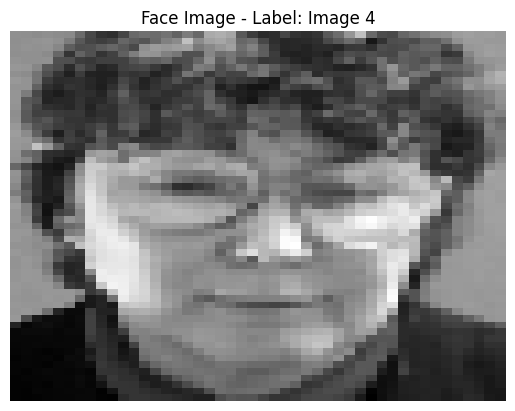

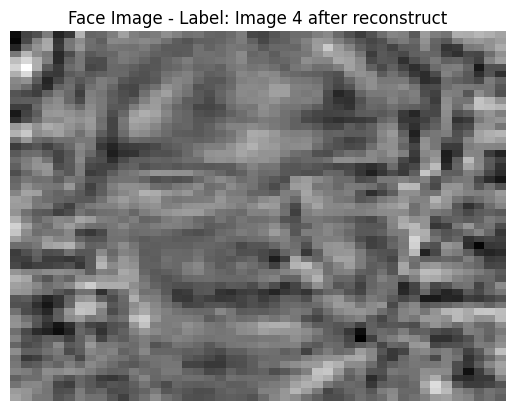

5150604.91896529


In [23]:
def test_image_LDA(img_or, img, eigenvects, mean, W, mean_PCA, display=0):
    #Returns norm of reconstruction error, can display images
    
    projected = deconstruct(img, eigenvects, mean)
    print(projected.shape, eigenvects.shape, mean.shape)
    re_image = reconstruct(reconstruct(projected, eigenvects, mean), W.T, mean_PCA)
    
    if display :
        display_image(img_or, "Image 4")
        display_image(re_image, "Image 4 after reconstruct")
    return(np.linalg.norm(img_or-re_image))


#projections = np.array([deconstruct(X_train[i], eigenvectors_PCA, mean_PCA) for i in range(len(X_train))])
#mean_projected = np.mean(projections, axis=0)
#print(mean_projected.shape)
#print(projections.shape)

print(test_image(X[:, 1], Wopt, mean_PCA, 1))
#print(test_image_LDA(X_train[1, :], Xr[1,:], eigenvectors, mean, W, mean_PCA, 1))
#print(test_image_LDA(X[:, 1] , eigenvectors, mean_projected, eigenvectors_PCA, mean_PCA, 1))
#print(np.mean([test_image_LDA(X[:, i], eigenvectors, mean_projected, eigenvectors_PCA, mean_PCA, 0) for i in range(len(X[0]))]))  #mean error


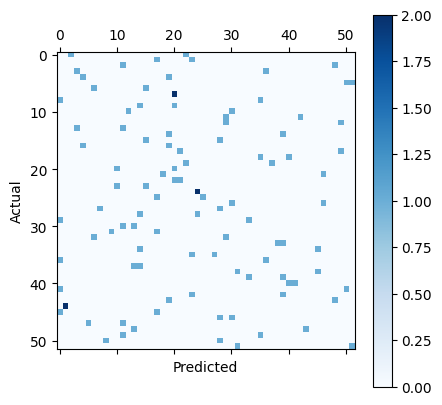

Accuracy :  0.11538461538461539


In [24]:
def testing_NN(image, projections, eigenvects, mean) :
    #Finds which training image correspond best to this image
    
    projected = deconstruct(image, eigenvects, mean)
    return np.argmin(np.linalg.norm((projections - projected), axis=1))

def fulltest(X_test, X_train, eigenvects, mean):
    #Compute all testing images and return guessed label
    
    projections = np.array([deconstruct(X_train[i], eigenvects, mean) for i in range(len(X_train))])
    res = []
    for image in X_test:
        res.append((testing_NN(image, projections, eigenvects, mean) //8) + 1)
    return np.array(res)

res = fulltest(X_test, X_train, Wopt, mean_PCA)

cm = confusion_matrix(l_test, res)

plt.matshow(cm, cmap = 'Blues')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print("Accuracy : ", sum(np.equal(res, l_test))/len(res))

In [25]:
pca = PCA(n_components=155)
pca.fit(X_train)
Xr = pca.transform(X_train)
Xt = pca.transform(X_test)
print("XR : ", Xr.shape)

lda = LinearDiscriminantAnalysis(store_covariance = True)
lda.fit(X_train, l_train)
res = lda.predict(X_test)

lda = LinearDiscriminantAnalysis(solver="eigen", n_components=51)
lda.fit(Xr, l_train)
res2 = lda.predict(Xt)




print("Covariance : ", lda.covariance_.shape)

cm = confusion_matrix(l_test, res)

plt.matshow(cm, cmap = 'Blues')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

cm2 = confusion_matrix(l_test, res2)

plt.matshow(cm2, cmap = 'Blues')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print("Accuracy (1) : ", sum(np.equal(res, l_test))/len(res))
print("Accuracy (2) : ", sum(np.equal(res2, l_test))/len(res2))


XR :  (416, 155)


KeyboardInterrupt: 

In [ ]:
tot = []
N=416
C=52
for Mpca in range(0, N-C+1):
    pca = PCA(n_components=Mpca)
    pca.fit(X_train)
    Xr = pca.transform(X_train)
    Xt = pca.transform(X_test)
    for Mlda in range(0, min(Mpca, C-1)+1):
        try:
            print(Mpca, Mlda)
            lda = LinearDiscriminantAnalysis(solver="eigen", n_components=Mlda)
            lda.fit(Xr, l_train)
            res = lda.predict(Xt)
            tot.append([Mpca, Mlda, np.sum(np.equal(res, l_test))/len(res)])
        except:
            tot.append([Mpca, Mlda, 0])
            
with open("output4.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(tot)

0 0
1 0
1 1
2 0
2 1
2 2
3 0
3 1
3 2
3 3
4 0
4 1
4 2
4 3
4 4
5 0
5 1
5 2
5 3
5 4
5 5
6 0
6 1
6 2
6 3
6 4
6 5
6 6
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
10 0
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 10
11 0
11 1
11 2
11 3
11 4
11 5
11 6
11 7
11 8
11 9
11 10
11 11
12 0
12 1
12 2
12 3
12 4
12 5
12 6
12 7
12 8
12 9
12 10
12 11
12 12
13 0
13 1
13 2
13 3
13 4
13 5
13 6
13 7
13 8
13 9
13 10
13 11
13 12
13 13
14 0
14 1
14 2
14 3
14 4
14 5
14 6
14 7
14 8
14 9
14 10
14 11
14 12
14 13
14 14
15 0
15 1
15 2
15 3
15 4
15 5
15 6
15 7
15 8
15 9
15 10
15 11
15 12
15 13
15 14
15 15
16 0
16 1
16 2
16 3
16 4
16 5
16 6
16 7
16 8
16 9
16 10
16 11
16 12
16 13
16 14
16 15
16 16
17 0
17 1
17 2
17 3
17 4
17 5
17 6
17 7
17 8
17 9
17 10
17 11
17 12
17 13
17 14
17 15
17 16
17 17
18 0
18 1
18 2
18 3
18 4
18 5
18 6
18 7
18 8
18 9
18 10
18 11
18 12
18 13
18 14
18 15
18 16
18 17
18 18
19 0
19 1
19 2
19 3
19 4
19 5
19 6
19 7
19 8
19 9
19 10
19 1

In [ ]:
data = pd.DataFrame(tot, columns=["Mpca", "Mlda", "accuracy"])

data.groupby("Mpca")["accuracy"].mean().to_csv("PCA-LDA_Mpca.csv", header=True)
data.groupby("Mlda")["accuracy"].mean().to_csv("PCA-LDA_Mlda.csv", header=True)

with open("PCA-LDA_accuracy.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(tot)


In [59]:
[X_train, X_test, l_train, l_test] = Q1_partition(data)

def Ensemble_data(X, y, T, f, C, Mlda):
    clfs = []
    for i in range(T) :
        X_sampled = []
        y_sampled = []
        for j in range(C):
            sampled_indices = np.random.choice(8, f, replace=True) + j*8
            X_sampled.append(X[sampled_indices])
            y_sampled.append(y[sampled_indices])
        X_sampled = np.concatenate(X_sampled)
        y_sampled = np.concatenate(y_sampled)
        lda = LinearDiscriminantAnalysis(n_components=Mlda)
        lda.fit(X_sampled, y_sampled)
        clfs.append(lda)
    return clfs
    
def Prediction_d(clfs, X_test, l_test, C):
    res = np.zeros((l_test.shape[0], C))
    for clf in clfs :
        res += clf.predict_proba(X_test)
    return np.argmax(res, axis=1) + 1
    
    
pca = PCA(n_components = 155)
pca.fit(X_train)
Xr = pca.transform(X_train)
Xt = pca.transform(X_test)
x = 20
mean = 0
for i in range(x):
    Classifiers = Ensemble_data(Xr, l_train, 50, 5, 52, 51)
    res = Prediction_d(Classifiers, Xt, l_test, 52)
    mean += np.sum(np.equal(res, l_test))/len(res)
print(mean/x)


KeyboardInterrupt: 

In [32]:

tot_results = []

for Mpca in range(155, 156):
    print("PCA : ", Mpca)
    pca = PCA(n_components = Mpca)
    pca.fit(X_train)
    Xr = pca.transform(X_train)
    Xt = pca.transform(X_test)
    for Mlda in range(51, 52):
        print("LDA : ", Mlda)
        for T in range(1, 50):
            for f in range(2, 8):
                x = 20
                mean = 0
                for i in range(x):
                    Classifiers = Ensemble_data(Xr, l_train, T, f, 52, Mlda)
                    res = Prediction_d(Classifiers, Xt, l_test, 52)
                    mean += np.sum(np.equal(res, l_test))/len(res)
                tot_results.append([Mpca, Mlda, T, f, mean/x])
        

PCA :  155
LDA :  51


In [33]:
data = pd.DataFrame(tot_results, columns=["Mpca", "Mlda", "T", "f", "accuracy"])

data.groupby("T")["accuracy"].mean().to_csv("Ensemble_T.csv", header=True)
data.groupby("f")["accuracy"].mean().to_csv("Ensemble_f.csv", header=True)

with open("Ensemble_accuracy.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(tot_results)        


In [ ]:
pca = PCA(n_components=100)
pca.fit(X_train)
Xr = pca.transform(X_train)
Xt = pca.transform(X_test)

x = 10
mean = 0
for i in range(x):
    Classifiers = Ensemble_data(Xr, l_train, 15, 0.95, 52, 26)
    res = Prediction_d(Classifiers, Xt, l_test, 52)
    mean += np.sum(np.equal(res, l_test))/len(res)
print(mean/x)


0.928846153846154


In [ ]:

"""
cm = confusion_matrix(l_test, res)

plt.matshow(cm, cmap = 'Blues')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
"""

In [1]:
class RandomizedPCA_LDA(BaseEstimator, ClassifierMixin):
    def __init__(self, n_components_pca=5, n_components_lda=1, feature_ratio=0.8):
        self.n_components_pca = n_components_pca
        self.n_components_lda = n_components_lda
        self.feature_ratio = feature_ratio
        self.selected_features = None
        self.pca = None
        self.lda = None

    def fit(self, X, y):
        # Randomly select a subset of features
        n_features = X.shape[1]
        n_selected_features = int(n_features * self.feature_ratio)
        self.selected_features = np.random.choice(n_features, n_selected_features, replace=False)
        
        # Apply PCA on the selected features
        self.pca = PCA(n_components=self.n_components_pca)
        X_reduced = self.pca.fit_transform(X[:, self.selected_features])
        
        # Apply LDA on the PCA-transformed data
        self.lda = LinearDiscriminantAnalysis(n_components=self.n_components_lda)
        self.lda.fit(X_reduced, y)
        return self

    def predict(self, X):
        X_reduced = self.pca.transform(X[:, self.selected_features])
        return self.lda.predict_proba(X_reduced)
    
def Ensemble_feature(X, y, T, n_components_pca=5, n_components_lda=1, feature_ratio=0.8):
    classifiers = []
    for i in range(T):
        classifier = RandomizedPCA_LDA(n_components_pca, n_components_lda, feature_ratio)
        classifier.fit(X, y)
        classifiers.append(classifier)
    
    return classifiers

def Prediction_f(clfs, X_test, l_test, C):
    res = np.zeros((l_test.shape[0], C))
    for clf in clfs :
        res += clf.predict(X_test)
    return np.argmax(res, axis=1) + 1

Classifiers = Ensemble_feature(X_train, l_train, T=25, n_components_pca=200, n_components_lda=51, feature_ratio=0.8)

res = Prediction_f(Classifiers, X_test, l_test, 52)

cm = confusion_matrix(l_test, res)

plt.matshow(cm, cmap = 'Blues')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print("Accuracy : ", sum(np.equal(res, l_test))/len(res))


NameError: name 'BaseEstimator' is not defined

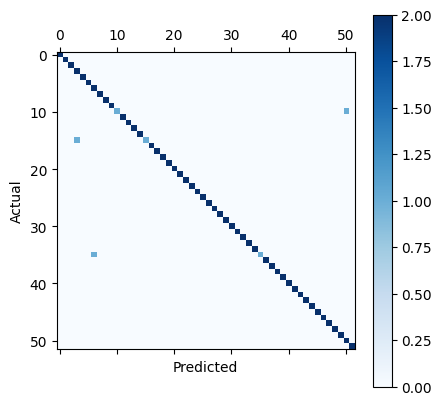

Accuracy :  0.9711538461538461


'\ntot_results = []\n\nfor Mlda in range(51, 52):\n    for M0 in range(70, 110, 2):\n        for M1 in range(110, 170, 4):\n            for T in range(25, 26):\n                x = 10\n                mean = 0\n                for i in range(x):\n                    Classifiers = Ensemble_feature(Xr, l_train, T, M0, M1, Mlda)\n                    res = Prediction_f(Classifiers, Xt, l_test, 52)\n                    mean += np.sum(np.equal(res, l_test))/len(res)\n                print(T, M0, M1, Mlda, mean/x)\n                tot_results.append([Mlda, M0, M1, T, mean/x])\n'

In [9]:
def Ensemble_feature(X, y, T, M0, M1, Mlda):
    clfs = []
    
    for i in range(T) :
        selected_features = np.random.choice(np.arange(M0+1,X.shape[0]-1), M1, replace=False)
        f_random = np.concatenate([np.arange(M0), selected_features])
        lda = LinearDiscriminantAnalysis(solver="eigen", n_components=Mlda)
        lda.fit(X[:,f_random], y)
        clfs.append([lda, f_random])
    return clfs
    
def Prediction_f(clfs, X_test, l_test, C):
    res = np.zeros((l_test.shape[0], C))
    for clf in clfs :
        res += clf[0].predict_proba(X_test[:,clf[1]])
    return np.argmax(res, axis=1) + 1

[X_train, X_test, l_train, l_test] = Q1_partition(data)

pca = PCA(n_components=415)
pca.fit(X_train)
Xr = pca.transform(X_train)
Xt = pca.transform(X_test)

Classifiers = Ensemble_feature(Xr, l_train, T=25, M0=102, M1=150, Mlda=51)
res = Prediction_f(Classifiers, Xt, l_test, 52)

cm = confusion_matrix(l_test, res)

plt.matshow(cm, cmap = 'Blues')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print("Accuracy : ", np.sum(np.equal(res, l_test))/len(res))


"""
tot_results = []

for Mlda in range(51, 52):
    for M0 in range(70, 110, 2):
        for M1 in range(110, 170, 4):
            for T in range(25, 26):
                x = 10
                mean = 0
                for i in range(x):
                    Classifiers = Ensemble_feature(Xr, l_train, T, M0, M1, Mlda)
                    res = Prediction_f(Classifiers, Xt, l_test, 52)
                    mean += np.sum(np.equal(res, l_test))/len(res)
                print(T, M0, M1, Mlda, mean/x)
                tot_results.append([Mlda, M0, M1, T, mean/x])
"""
                


In [7]:
with open("Ensemblef2_accuracy_nxt.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(tot_results)

In [72]:
data = pd.DataFrame(tot_results, columns=["Mlda", "M0", "M1", "T", "accuracy"])
print(data)
data.groupby("T")["accuracy"].mean().to_csv("Ensemblef2_T.csv", header=True)
data.groupby("M0")["accuracy"].mean().to_csv("Ensemblef2_M0.csv", header=True)
data.groupby("M1")["accuracy"].mean().to_csv("Ensemblef2_M1.csv", header=True)

with open("Ensemblef2_accuracy.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(tot_results)


     Mlda   M0  M1   T  accuracy
0      51   70  51  15  0.948077
1      51   70  51  20  0.950000
2      51   70  51  25  0.951923
3      51   70  71  15  0.967308
4      51   70  71  20  0.965385
..    ...  ...  ..  ..       ...
625    51  255  51  20  0.917308
626    51  255  51  25  0.915385
627    51  260  51  15  0.921154
628    51  260  51  20  0.911538
629    51  260  51  25  0.923077

[630 rows x 5 columns]
